<div style="background:#FFFFE0;padding:20px;color:#000000;margin-top:10px;">
Imports necesarios para la ejecución de los módulos instalados con pip:

• pandas → import pandas as pd  
• numpy → import numpy as np  
• matplotlib → import matplotlib.pyplot as plt  
• seaborn → import seaborn as sns  
• scikit-learn → from sklearn.model_selection import train_test_split  
                    from sklearn.metrics import classification_report, confusion_matrix  
• torch → import torch  
• transformers → from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding  
• datasets → from datasets import Dataset  
</div>


In [12]:
#pip install transformers datasets scikit-learn pandas matplotlib seaborn torch
#!pip install "transformers[torch]" --upgrade


In [111]:
#!pip install "transformers[torch]" --upgrade
#!pip install --upgrade transformers


In [14]:
#!pip install --upgrade transformers accelerate


In [20]:
#!pip install evaluate


<div style="background:#FFFFE0;padding:20px;color:#000000;margin-top:10px;">
Este bloque de código verifica si PyTorch puede usar la GPU (usualmente con CUDA) y cuál GPU está disponible. Es útil para asegurarse de que el entrenamiento del modelo se pueda hacer con aceleración por hardware, lo que reduce significativamente el tiempo.</div>


In [15]:
import torch

print("CUDA disponible:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

CUDA disponible: True
GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU


# Clasificacion automatica de poemas segun su forma poetica(usando la carpeta forms)

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset
import torch

In [6]:
import os
import pandas as pd

ruta_base = "archive/forms"

# Inicializamos listas vacías
textos = []
etiquetas = []

# Recorrer cada carpeta (que es una clase)
for nombre_carpeta in os.listdir(ruta_base):
    ruta_carpeta = os.path.join(ruta_base, nombre_carpeta)
    if os.path.isdir(ruta_carpeta):
        for archivo in os.listdir(ruta_carpeta):
            ruta_archivo = os.path.join(ruta_carpeta, archivo)
            try:
                with open(ruta_archivo, 'r', encoding='utf-8') as f:
                    contenido = f.read().strip()
                    textos.append(contenido)
                    etiquetas.append(nombre_carpeta)
            except:
                continue

# Crear el DataFrame
df = pd.DataFrame({'text': textos, 'label': etiquetas})

# Ver los primeros datos
print(df.head())
print(df['label'].value_counts().to_string())


                                                text label
0  2 ABC of H.k. and China revised vision.\nBarre...   abc
1  Apparently life without love, is no life at al...   abc
2  A abc angles on angels flaws (poem)\nMix with ...   abc
3  A abc Brazil dance (poem)\nJack of crack in po...   abc
4  ABC... I can't go on\n123... what's the next o...   abc
label
acrostic                       100
allegory                       100
free-verse                     100
cinquain                       100
cavatina                       100
ballad                         100
ballade                        100
tetractys                      100
triolet                        100
villanelle                     100
stanza                         100
syllabic-verse                 100
epigram                        100
dirge                          100
clerihew                       100
epitaph                        100
elegy                          100
epistle                        100
verse     

In [14]:
from sklearn.preprocessing import LabelEncoder

# Etiquetas que sí quieres mantener con su nombre
clases_deseadas = ['haiku', 'sonnet']

# Reasignamos todo lo que no es haiku ni sonnet como "otros"
df['label'] = df['label'].apply(lambda x: x if x in clases_deseadas else 'otros')

# Ahora sí codificamos las tres clases
le = LabelEncoder()
df['label_id'] = le.fit_transform(df['label'])

# Imprimir para verificar
print(df['label'].value_counts())
print(df['label_id'].value_counts())
print(le.classes_)  # Te dirá cuál clase es cuál número


label
otros     6140
haiku       99
sonnet      79
Name: count, dtype: int64
label_id
1    6140
0      99
2      79
Name: count, dtype: int64
['haiku' 'otros' 'sonnet']


In [16]:
from transformers import BertTokenizer

# Cargar el tokenizer de BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

dataset = Dataset.from_pandas(df[['text', 'label_id']])
tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.rename_column("label_id", "labels")



Map: 100%|██████████| 6318/6318 [00:22<00:00, 276.68 examples/s]


In [21]:
# Dividir en entrenamiento y prueba (80% - 20%)
split_dataset = tokenized_dataset.train_test_split(test_size=0.2, seed=42)

# Asignar a variables por claridad
train_dataset = split_dataset['train']
eval_dataset = split_dataset['test']

# Confirmar tamaños
print(f"Entrenamiento: {len(train_dataset)} ejemplos")
print(f"Evaluación: {len(eval_dataset)} ejemplos")



Entrenamiento: 5054 ejemplos
Evaluación: 1264 ejemplos


In [22]:
from transformers import BertForSequenceClassification

# Indicar la cantidad de clases (por ejemplo: 3 si tienes haiku, sonnet y otros)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


con 3 epecas hay confuncion en varios poemas

In [44]:
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding

# Preparar colador de datos
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Argumentos básicos de entrenamiento compatibles
training_args = TrainingArguments(
    output_dir="./resultados",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    logging_dir="./logs"
)

# Definir Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Entrenar
trainer.train()


C:\Users\scout\AppData\Local\Temp\ipykernel_18764\2977003183.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.061800
1000,0.022300
1500,0.014400
2000,0.008800
2500,0.004700
3000,0.003100


c:\Users\scout\anaconda3\envs\nlp-env\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\scout\anaconda3\envs\nlp-env\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\scout\anaconda3\envs\nlp-env\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\scout\anaconda3\envs\nlp-env\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return fo

TrainOutput(global_step=3160, training_loss=0.018526437275017363, metrics={'train_runtime': 712.8334, 'train_samples_per_second': 35.45, 'train_steps_per_second': 4.433, 'total_flos': 1662219016496640.0, 'train_loss': 0.018526437275017363, 'epoch': 5.0})

In [47]:
model.save_pretrained("./modelo_poemasv2")
tokenizer.save_pretrained("./modelo_poemasv2")


('./modelo_poemasv2\\tokenizer_config.json',
 './modelo_poemasv2\\special_tokens_map.json',
 './modelo_poemasv2\\vocab.txt',
 './modelo_poemasv2\\added_tokens.json')

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

# Cargar modelo entrenado
modelo_entrenado = BertForSequenceClassification.from_pretrained("./modelo_poemasv2")
tokenizer_entrenado = BertTokenizer.from_pretrained("./modelo_poemasv2")


In [5]:
import torch

poema = """One of the four great masters of Japanese haiku, Matsuo Bashō is known for his simplistic yet thought-provoking haikus. “The Old Pond”, arguably his most famous piece, stays true to his style of couching observations of human nature within natural imagery. One interpretation is that by metaphorically using the ‘pond’ to symbolize the mind, Bashō brings to light the impact of external stimuli (embodied by the frog, a traditional subject of Japanese poetry) on the human mind. 
"""

# Preparar input
inputs = tokenizer_entrenado(poema, return_tensors="pt", padding='max_length', truncation=True, max_length=128)
inputs = {k: v.to(modelo_entrenado.device) for k, v in inputs.items()}

# Predecir
modelo_entrenado.eval()
with torch.no_grad():
    outputs = modelo_entrenado(**inputs)
    logits = outputs.logits
    predicted_class_id = logits.argmax().item()

print("Predicción:", le.classes_[predicted_class_id])  


NameError: name 'le' is not defined

In [50]:
import os
import torch
import torch.nn.functional as F
from transformers import BertTokenizer, BertForSequenceClassification
from pathlib import Path

# Cargar modelo y tokenizer
model_path = "./modelo_poemasv2"
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Clases en el mismo orden del entrenamiento
labels = ["haiku", "sonnet", "otros"]

# Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Carpeta con los archivos .txt
carpeta_poemas = "./Poemasvar"

# Umbral de confianza para decir "desconocido"
umbral_confianza = 0.65  # puedes ajustar entre 0.5 y 0.7 según tu preferencia

# Recorrer todos los archivos .txt
for archivo in Path(carpeta_poemas).glob("*.txt"):
    with open(archivo, "r", encoding="utf-8") as f:
        texto = f.read().strip()

    # Tokenizar
    inputs = tokenizer(texto, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Predicción
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = F.softmax(logits, dim=-1)
        confidence, pred_id = torch.max(probs, dim=1)

    # Evaluar confianza
    if confidence.item() < umbral_confianza:
        clase_predicha = "desconocido"
    else:
        clase_predicha = labels[pred_id.item()]

    print(f"{archivo.name}: {clase_predicha} (confianza: {confidence.item():.2f})")


haiku10_masaoka_shiki_cold.txt: sonnet (confianza: 1.00)
haiku11_modern_sea.txt: sonnet (confianza: 1.00)
haiku12_modern_lanterns.txt: sonnet (confianza: 1.00)
haiku13_modern_train.txt: sonnet (confianza: 1.00)
haiku14_modern_rain.txt: sonnet (confianza: 1.00)
haiku15_modern_moon.txt: haiku (confianza: 1.00)
haiku16_modern_street.txt: haiku (confianza: 1.00)
haiku17_modern_coffee.txt: sonnet (confianza: 1.00)
haiku18_modern_tree.txt: sonnet (confianza: 1.00)
haiku19_modern_beach.txt: sonnet (confianza: 1.00)
haiku1_matsuo_basho_frog.txt: haiku (confianza: 1.00)
haiku20_modern_fireflies.txt: sonnet (confianza: 1.00)
haiku2_matsuo_basho_autumn.txt: haiku (confianza: 1.00)
haiku3_matsuo_basho_summer.txt: sonnet (confianza: 1.00)
haiku4_yosa_buson_butterfly.txt: sonnet (confianza: 1.00)
haiku5_yosa_buson_moon.txt: sonnet (confianza: 1.00)
haiku6_kobayashi_issa_snail.txt: sonnet (confianza: 1.00)
haiku7_kobayashi_issa_dewdrop.txt: sonnet (confianza: 1.00)
haiku8_kobayashi_issa_child.txt: so

Modelo con las clases balanceadas


In [32]:
import os
import pandas as pd

ruta_base = "archive/forms"

# Inicializamos listas vacías
textos = []
etiquetas = []

# Recorrer cada carpeta (que es una clase)
for nombre_carpeta in os.listdir(ruta_base):
    ruta_carpeta = os.path.join(ruta_base, nombre_carpeta)
    if os.path.isdir(ruta_carpeta):
        for archivo in os.listdir(ruta_carpeta):
            ruta_archivo = os.path.join(ruta_carpeta, archivo)
            try:
                with open(ruta_archivo, 'r', encoding='utf-8') as f:
                    contenido = f.read().strip()
                    textos.append(contenido)
                    etiquetas.append(nombre_carpeta)
            except:
                continue

# Crear el DataFrame
df = pd.DataFrame({'text': textos, 'label': etiquetas})


In [33]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['label_id'] = le.fit_transform(df['label'])  

In [35]:
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder

# Reasignar etiquetas no deseadas como "otros"
clases_deseadas = ['haiku', 'sonnet']
df['label'] = df['label'].apply(lambda x: x if x in clases_deseadas else 'otros')

# Codificar etiquetas
le = LabelEncoder()
df['label_id'] = le.fit_transform(df['label'])
print("Clases codificadas:", list(le.classes_))  # ['haiku', 'otros', 'sonnet']

# Separar por clase
df_haiku = df[df['label'] == 'haiku']
df_sonnet = df[df['label'] == 'sonnet']
df_otros = df[df['label'] == 'otros']

# Fijar tamaño objetivo (igual al tamaño de la clase minoritaria más grande)
target_size = max(len(df_haiku), len(df_sonnet))  # en este caso, 99

# Reamostrar cada clase al tamaño objetivo
df_haiku_up = resample(df_haiku, replace=True, n_samples=target_size, random_state=42)
df_sonnet_up = resample(df_sonnet, replace=True, n_samples=target_size, random_state=42)
df_otros_down = resample(df_otros, replace=False, n_samples=target_size, random_state=42)

# Combinar y mezclar
df_balanced = pd.concat([df_haiku_up, df_sonnet_up, df_otros_down])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Verificación
print("Distribución balanceada final:")
print(df_balanced['label'].value_counts())


Clases codificadas: ['haiku', 'otros', 'sonnet']
Distribución balanceada final:
label
sonnet    99
otros     99
haiku     99
Name: count, dtype: int64


In [36]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_balanced['text'], df_balanced['label_id'], test_size=0.2, stratify=df_balanced['label_id'], random_state=42
)


In [37]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=256)

# Convertimos a formato Dataset de Hugging Face
from datasets import Dataset

train_dataset = Dataset.from_pandas(pd.DataFrame({'text': train_texts, 'label': train_labels}))
val_dataset = Dataset.from_pandas(pd.DataFrame({'text': val_texts, 'label': val_labels}))

# Aplicamos la tokenización
train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)


Map: 100%|██████████| 60/60 [00:00<00:00, 3461.27 examples/s]


In [38]:
train_dataset = train_dataset.remove_columns(['text', '__index_level_0__'])
val_dataset = val_dataset.remove_columns(['text', '__index_level_0__'])

train_dataset.set_format('torch')
val_dataset.set_format('torch')


In [39]:
from transformers import BertForSequenceClassification, TrainingArguments, Trainer

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./resultados_balanceado4",
    do_train=True,
    do_eval=True,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=6,
    logging_dir="./logs_balanceado4"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\scout\AppData\Local\Temp\ipykernel_46228\2784539424.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
c:\Users\scout\anaconda3\envs\nlp-env\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss


TrainOutput(global_step=180, training_loss=0.32196506924099394, metrics={'train_runtime': 1432.9251, 'train_samples_per_second': 0.992, 'train_steps_per_second': 0.126, 'total_flos': 187073640004608.0, 'train_loss': 0.32196506924099394, 'epoch': 6.0})

In [40]:
# Guardar modelo y tokenizer
trainer.save_model("./modelo_balanceado4")
tokenizer.save_pretrained("./modelo_balanceado4")


('./modelo_balanceado4\\tokenizer_config.json',
 './modelo_balanceado4\\special_tokens_map.json',
 './modelo_balanceado4\\vocab.txt',
 './modelo_balanceado4\\added_tokens.json',
 './modelo_balanceado4\\tokenizer.json')

In [43]:
import os
import torch
import torch.nn.functional as F
from transformers import BertTokenizer, BertForSequenceClassification
from pathlib import Path

# Cargar modelo y tokenizer
model_path = "./modelo_balanceado4"
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Clases en el mismo orden del entrenamiento
labels = ["haiku", "sonnet", "otros"]

# Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Carpeta con los archivos .txt
carpeta_poemas = "./Poemasvar"

# Umbral de confianza para decir "desconocido"
umbral_confianza = 0.60 # puedes ajustar entre 0.5 y 0.7 según tu preferencia

# Recorrer todos los archivos .txt
for archivo in Path(carpeta_poemas).glob("*.txt"):
    with open(archivo, "r", encoding="utf-8") as f:
        texto = f.read().strip()

    # Tokenizar
    inputs = tokenizer(texto, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Predicción
    # Evaluar confianza y predecir
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = F.softmax(logits, dim=-1)
        confidence, pred_id = torch.max(probs, dim=1)

        if confidence.item() < umbral_confianza:
            clase_predicha = "otros"
        else:
            clase_predicha = labels[pred_id.item()]

    print(f"{archivo.name}: {clase_predicha} (confianza: {confidence.item():.2f})")



haiku10_masaoka_shiki_cold.txt: haiku (confianza: 0.90)
haiku11_modern_sea.txt: haiku (confianza: 0.95)
haiku12_modern_lanterns.txt: haiku (confianza: 0.97)
haiku13_modern_train.txt: haiku (confianza: 0.97)
haiku14_modern_rain.txt: haiku (confianza: 0.97)
haiku15_modern_moon.txt: haiku (confianza: 0.97)
haiku16_modern_street.txt: haiku (confianza: 0.97)
haiku17_modern_coffee.txt: haiku (confianza: 0.97)
haiku18_modern_tree.txt: haiku (confianza: 0.98)
haiku19_modern_beach.txt: haiku (confianza: 0.98)
haiku1_matsuo_basho_frog.txt: haiku (confianza: 0.98)
haiku20_modern_fireflies.txt: haiku (confianza: 0.97)
haiku2_matsuo_basho_autumn.txt: haiku (confianza: 0.97)
haiku3_matsuo_basho_summer.txt: haiku (confianza: 0.80)
haiku4_yosa_buson_butterfly.txt: haiku (confianza: 0.97)
haiku5_yosa_buson_moon.txt: haiku (confianza: 0.97)
haiku6_kobayashi_issa_snail.txt: haiku (confianza: 0.97)
haiku7_kobayashi_issa_dewdrop.txt: otros (confianza: 0.57)
haiku8_kobayashi_issa_child.txt: haiku (confianza

c:\Users\scout\anaconda3\envs\nlp-env\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



REPORTE DE CLASIFICACION:

              precision    recall  f1-score   support

       haiku      0.594     0.950     0.731        20
      sonnet      0.696     0.800     0.744        20
       otros      0.000     0.000     0.000        20

    accuracy                          0.583        60
   macro avg      0.430     0.583     0.492        60
weighted avg      0.430     0.583     0.492        60



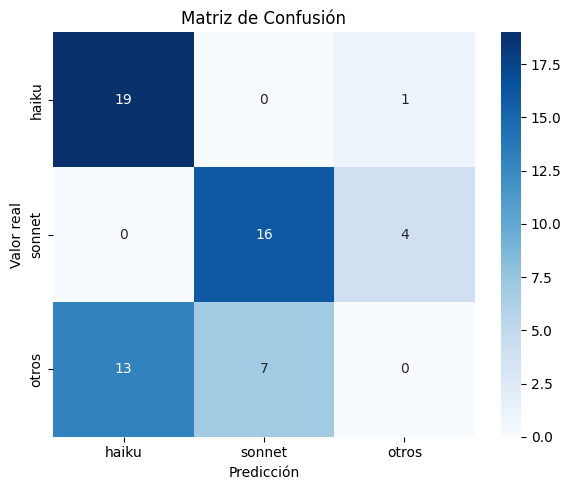

In [44]:
import os
import torch
import torch.nn.functional as F
from transformers import BertTokenizer, BertForSequenceClassification
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración
model_path = "./modelo_balanceado4"
carpeta_poemas = "./Poemasvar"
labels = ["haiku", "sonnet", "otros"]
umbral_confianza = 0.60

# Cargar modelo y tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Listas para almacenar resultados
true_labels = []
pred_labels = []

# Recorrer archivos
for archivo in Path(carpeta_poemas).glob("*.txt"):
    nombre = archivo.name.lower()
    if "haiku" in nombre:
        true_label = "haiku"
    elif "sonnet" in nombre:
        true_label = "sonnet"
    else:
        true_label = "otros"

    with open(archivo, "r", encoding="utf-8") as f:
        texto = f.read().strip()

    inputs = tokenizer(texto, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = F.softmax(logits, dim=-1)
        confidence, pred_id = torch.max(probs, dim=1)

    pred_label = labels[pred_id.item()]
    pred_labels.append(pred_label)
    true_labels.append(true_label)

# Mostrar reporte
print("\nREPORTE DE CLASIFICACION:\n")
print(classification_report(true_labels, pred_labels, labels=labels, digits=3))

# Matriz de confusión
cm = confusion_matrix(true_labels, pred_labels, labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.show()


Evaluando: modelo_poemas


c:\Users\scout\anaconda3\envs\nlp-env\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

       haiku       0.86      0.30      0.44        20
      sonnet       0.00      0.00      0.00        20
       otros       0.35      0.90      0.51        20

    accuracy                           0.40        60
   macro avg       0.40      0.40      0.32        60
weighted avg       0.40      0.40      0.32        60



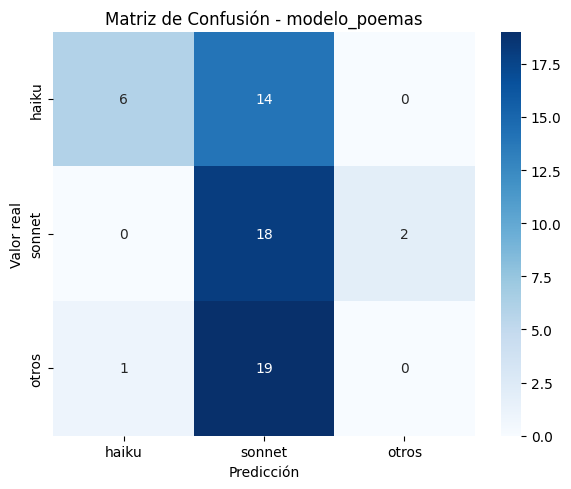

Evaluando: modelo_poemasv2


c:\Users\scout\anaconda3\envs\nlp-env\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

       haiku       0.62      0.25      0.36        20
      sonnet       0.00      0.00      0.00        20
       otros       0.36      0.90      0.51        20

    accuracy                           0.38        60
   macro avg       0.33      0.38      0.29        60
weighted avg       0.33      0.38      0.29        60



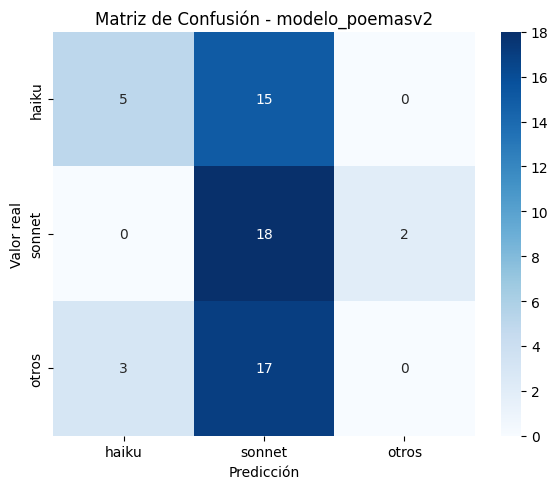

Evaluando: modelo_balanceado


c:\Users\scout\anaconda3\envs\nlp-env\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

       haiku       0.44      0.20      0.28        20
      sonnet       0.29      0.75      0.42        20
       otros       0.00      0.00      0.00        20

    accuracy                           0.32        60
   macro avg       0.25      0.32      0.23        60
weighted avg       0.25      0.32      0.23        60



c:\Users\scout\anaconda3\envs\nlp-env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\scout\anaconda3\envs\nlp-env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\scout\anaconda3\envs\nlp-env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

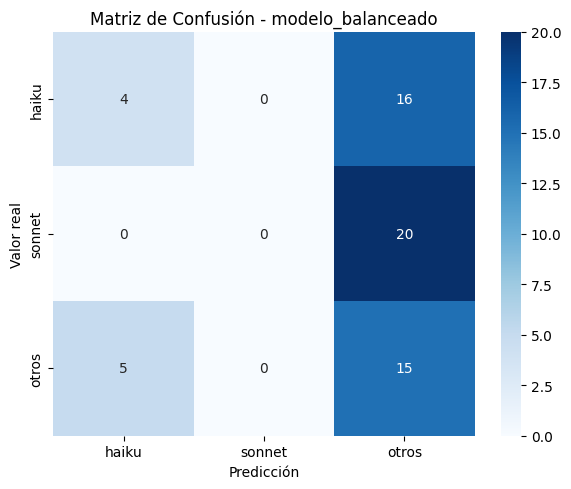

Evaluando: modelo_balanceado2


c:\Users\scout\anaconda3\envs\nlp-env\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

       haiku       0.38      0.15      0.21        20
      sonnet       0.29      0.75      0.42        20
       otros       0.00      0.00      0.00        20

    accuracy                           0.30        60
   macro avg       0.22      0.30      0.21        60
weighted avg       0.22      0.30      0.21        60



c:\Users\scout\anaconda3\envs\nlp-env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\scout\anaconda3\envs\nlp-env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\scout\anaconda3\envs\nlp-env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

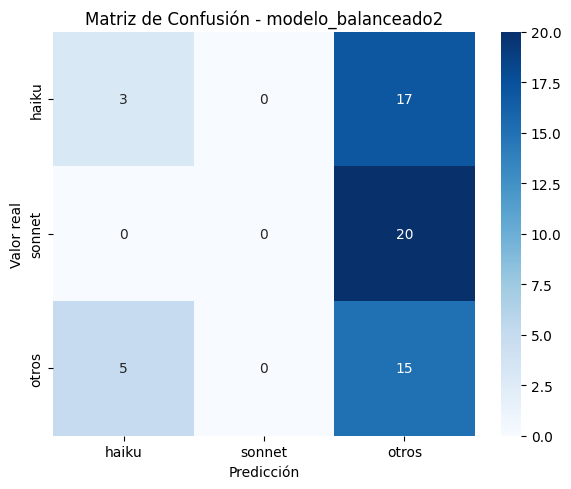

Evaluando: modelo_balanceado3


c:\Users\scout\anaconda3\envs\nlp-env\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

       haiku       0.65      1.00      0.78        20
      sonnet       0.00      0.00      0.00        20
       otros       0.64      0.80      0.71        20

    accuracy                           0.60        60
   macro avg       0.43      0.60      0.50        60
weighted avg       0.43      0.60      0.50        60



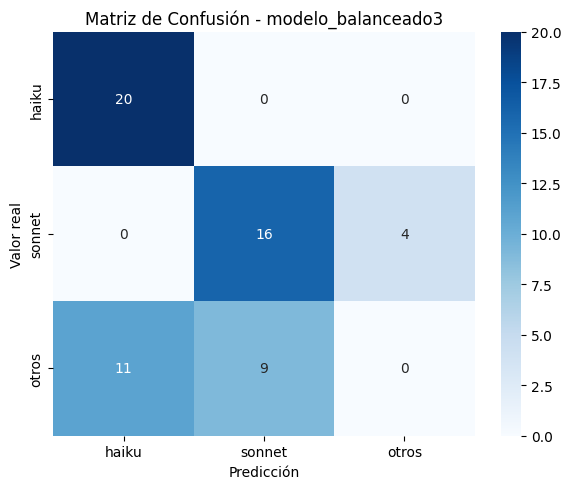

Evaluando: modelo_balanceado4


c:\Users\scout\anaconda3\envs\nlp-env\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

       haiku       0.59      0.95      0.73        20
      sonnet       0.00      0.00      0.00        20
       otros       0.70      0.80      0.74        20

    accuracy                           0.58        60
   macro avg       0.43      0.58      0.49        60
weighted avg       0.43      0.58      0.49        60



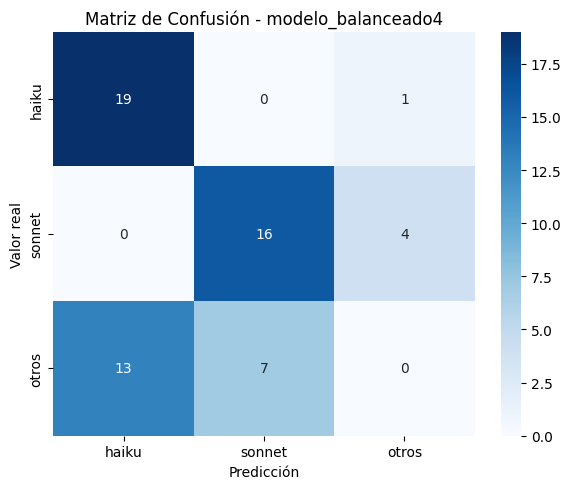

In [45]:
import os
import torch
import torch.nn.functional as F
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# Carpetas con modelos
modelos = [
    "modelo_poemas",
    "modelo_poemasv2",
    "modelo_balanceado",
    "modelo_balanceado2",
    "modelo_balanceado3",
    "modelo_balanceado4"
]

# Clases
labels = ["haiku", "sonnet", "otros"]

# Archivos de prueba
carpeta_poemas = "./Poemasvar"
archivos_txt = sorted(Path(carpeta_poemas).glob("*.txt"))

# Cargar textos
textos = []
nombres = []
for archivo in archivos_txt:
    with open(archivo, "r", encoding="utf-8") as f:
        textos.append(f.read().strip())
        nombres.append(archivo.name)

# Etiquetas reales según nombre del archivo
y_true = []
for nombre in nombres:
    if "haiku" in nombre.lower():
        y_true.append("haiku")
    elif "sonnet" in nombre.lower():
        y_true.append("sonnet")
    else:
        y_true.append("otros")

# Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tokenizer base
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Evaluar cada modelo
for modelo_path in modelos:
    print("="*60)
    print(f"Evaluando: {modelo_path}")
    print("="*60)

    # Cargar modelo
    model = BertForSequenceClassification.from_pretrained(modelo_path)
    model.to(device)
    model.eval()

    # Predicciones
    y_pred = []
    for texto in textos:
        inputs = tokenizer(texto, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            pred_id = torch.argmax(logits, dim=-1).item()
            y_pred.append(labels[pred_id])

    # Reporte
    print("\nREPORTE DE CLASIFICACIÓN:")
    print(classification_report(y_true, y_pred, target_names=labels))

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicción")
    plt.ylabel("Valor real")
    plt.title(f"Matriz de Confusión - {modelo_path}")
    plt.tight_layout()
    plt.show()


c:\Users\scout\anaconda3\envs\nlp-env\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


               Modelo  Accuracy  F1-score macro
0       modelo_poemas  0.450000        0.387158
1     modelo_poemasv2  0.400000        0.341558
2   modelo_balanceado  0.400000        0.279747
3  modelo_balanceado2  0.383333        0.256614
4  modelo_balanceado3  0.550000        0.505882
5  modelo_balanceado4  0.500000        0.458784


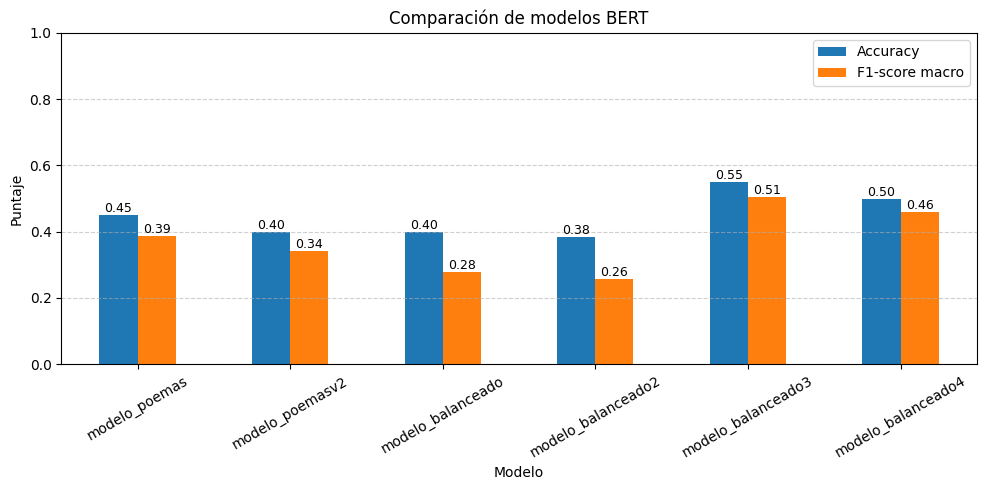

In [47]:
import os
import torch
import torch.nn.functional as F
from transformers import BertTokenizer, BertForSequenceClassification
from pathlib import Path
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt

# === CONFIGURACIÓN ===

# Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Labels en el mismo orden del entrenamiento
labels = ["haiku", "sonnet", "otros"]

# Etiquetas verdaderas (20 de cada clase)
y_true = ["haiku"] * 20 + ["sonnet"] * 20 + ["otros"] * 20

# Modelos a comparar
modelos = [
    "modelo_poemas",
    "modelo_poemasv2",
    "modelo_balanceado",
    "modelo_balanceado2",
    "modelo_balanceado3",
    "modelo_balanceado4"
]

# Ruta de los poemas de prueba (60 archivos)
carpeta_poemas = "./Poemasvar"
archivos = sorted(Path(carpeta_poemas).glob("*.txt"))  # ordenado

# Tokenizador
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# === EVALUACIÓN DE MODELOS ===

y_pred_dict = {}

for modelo_path in modelos:
    model = BertForSequenceClassification.from_pretrained(modelo_path)
    model.to(device)
    model.eval()

    y_pred = []

    for archivo in archivos:
        with open(archivo, "r", encoding="utf-8") as f:
            texto = f.read().strip()

        inputs = tokenizer(texto, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            probs = F.softmax(logits, dim=-1)
            pred = torch.argmax(probs, dim=1).item()
            y_pred.append(labels[pred])

    y_pred_dict[modelo_path] = y_pred

# === COMPARACIÓN DE RESULTADOS ===

resultados = []

for modelo in modelos:
    y_pred = y_pred_dict[modelo]
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    resultados.append({
        "Modelo": modelo,
        "Accuracy": acc,
        "F1-score macro": f1
    })

# Crear DataFrame
df_resultados = pd.DataFrame(resultados)
print(df_resultados)

# === GRÁFICO COMPARATIVO ===

ax = df_resultados.set_index("Modelo")[["Accuracy", "F1-score macro"]].plot(
    kind="bar", figsize=(10, 5), ylim=(0, 1), rot=30
)
plt.title("Comparación de modelos BERT")
plt.ylabel("Puntaje")
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Mostrar valores encima de las barras
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=9)

plt.tight_layout()
plt.show()
